In [1]:
import pandas as pd
import numpy as np

In [2]:
#Reading csv dataset
data= pd.read_csv("mnist_train.csv")
test= pd.read_csv("mnist_test.csv")
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


A data key containing an array with one row per instance and one column per features

In [3]:
#Here we are diving the labels y and features X for both train and test data
X, y= data.drop("label", axis=1),data["label"]
test_X, test_y= test.drop("label", axis=1),test["label"]
X.shape

(60000, 784)

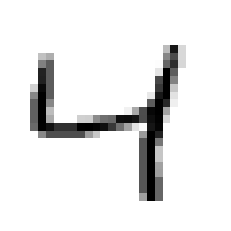

In [4]:
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn import preprocessing

#transform feature by scaling each feture individually such that it is in the given range on the training set X
min_max_scaler = preprocessing.MinMaxScaler()
digit=min_max_scaler.fit_transform(np.array(X))

#grabing an instance feature vector, reshape it to 28x28 array and display using matplotlib 
some_digit=digit[2,:]
some_digit_image= some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap=mlp.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[2]

4

In [6]:
# cast the string label to integer
y=y.astype(np.uint8)

In [7]:
# dataset is already split into training set (the first 60000 images) and test set (the last 10000 images)
X_train, X_test,y_train, y_test= X[:60000], X[60000:], y[:60000], y[60000:]

### training abinary classifier
only try to identify one digit "4-detector" (binary classifier)

In [8]:
y_train_4= (y_train==4)  #true for all 4s, False for all digits
y_test_4= (y_test==4)

In [9]:
from sklearn.linear_model import SGDClassifier 

sgd_cl=SGDClassifier(random_state=42)     #SGD deals with training instances independently one at a time
sgd_cl.fit(X_train, y_train_4)

SGDClassifier(random_state=42)

In [10]:
sgd_cl.predict([some_digit]) #predict the image in some_digit

array([False])

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_cl, X_train, y_train_4, cv=3, scoring= "accuracy")

array([0.9671 , 0.97645, 0.9687 ])

### Measure model performance
using confusion matrix evaluating the performance of classifier. To compute confusion matrix we need a set of prediction but we want to use test set only at the end of this project so we are using cross_val_predict() function it perform k-fold cross validation.

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred= cross_val_predict(sgd_cl, X_train, y_train_4) #we'll get prediction for each instance in the training set

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4, y_train_pred) #passing target classes and the predicted classes

array([[53283,   875],
       [  823,  5019]], dtype=int64)

### Precision and Recall
compute classifier matrices

In [14]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_4, y_train_pred) #correctly predicted only 85.15 of the time

0.8515439429928741

In [15]:
recall_score(y_train_4, y_train_pred) #detect image only 85.95 time

0.8591235878123931

In [16]:
#combining precision and recall into a single metric called F1 score
from sklearn.metrics import f1_score 
f1_score(y_train_4, y_train_pred)

0.8553169734151329

we cannot used threshold directly so we are using decision function to get score for each instance and then making prediction based on these score using any threshold 

In [17]:
y_scores=cross_val_predict(sgd_cl, X_train, y_train_4, cv=3, method="decision_function")

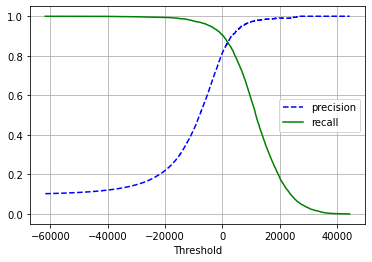

In [18]:
# plot precision and recall as function of threshold value using matplotlib
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds=precision_recall_curve(y_train_4,y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid()
    plt.show()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

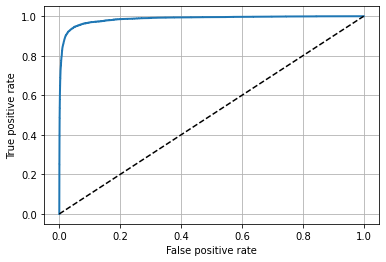

In [19]:
#receiver operating characteristic (ROC) curve plot true positive rate(recall) against the false positive rate
from sklearn.metrics import roc_curve
fpr, tpr, thresholds= roc_curve(y_train_4, y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.grid()
    
plot_roc_curve(fpr,tpr)
plt.show()

way to compare classifier is to measure area under the curve(AUC) scikit-learn provide a function to compute the roc and auc 

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_4, y_scores)

0.9859276923382874

### Train random forest classifier
compare its ROC curve and ROC AUC score to the SGD classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf= RandomForestClassifier(random_state=42)
#random forest have predict proba method that return an array containing a row per instance and a column per class
y_prabs= cross_val_predict(forest_clf, X_train, y_train_4, cv=3,method="predict_proba") 

In [22]:
# To plot ROC we need score not probability so we are using positive class probability as the score
y_score_forest= y_prabs[:,1]
fpr_forest, tpr_forest,threshold_forest= roc_curve(y_train_4, y_score_forest)

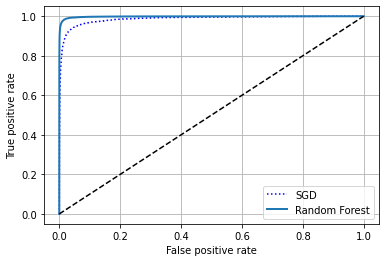

In [23]:
# plot ROC curve
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [24]:
roc_auc_score(y_train_4, y_score_forest) 

0.9982278527638186

ROC curve and roc_auc_score of random forest classifier is much better than SGD classifier

### Multiclass classifier
trains SGD on training set using the original target classes from 0 to 9 (y_train) and making prediction. scikit-learn trained 10 binary classifier, got their decision score for the image and selected the class with highest score

In [25]:
sgd_cl.fit(X_train, y_train) 
sgd_cl.predict([some_digit])

array([5], dtype=uint8)

In [26]:
some_digit_score=sgd_cl.decision_function([some_digit])
some_digit_score #it return 10 scores, one per class

array([[ -347.29361226,  -117.40236239,  -258.19636665,  -419.77510444,
         -160.75917964,    43.563021  ,  -376.41355315,   -65.03587296,
        -1321.40280451,  -623.43369561]])

In [27]:
np.argmax(some_digit_score)

5

In [28]:
sgd_cl.classes_[5]

5

In [29]:
# scaling inputs increase accuracy 
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_cl,X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error analysis

In [31]:
y_train_pred= cross_val_predict(sgd_cl, X_train_scaled, y_train, cv=3)
conf= confusion_matrix(y_train, y_train_pred)

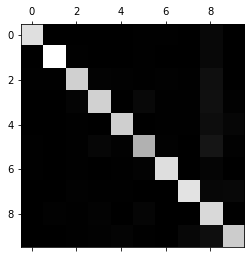

In [32]:
plt.matshow(conf, cmap=plt.cm.gray)
plt.show()

In [33]:
row_sum= conf.sum(axis=1, keepdims=True)
norm_conf= conf/row_sum

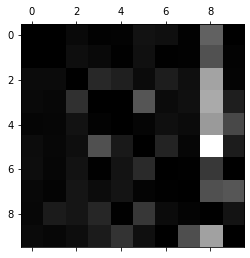

In [34]:
np.fill_diagonal(norm_conf,0)
plt.matshow(norm_conf, cmap=plt.cm.gray)
plt.show()